In [28]:
!pip install ucimlrepo

Missing values in features: 
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0
Soil_Type12                           0
Soil_Type13                           0
Soil_Type14

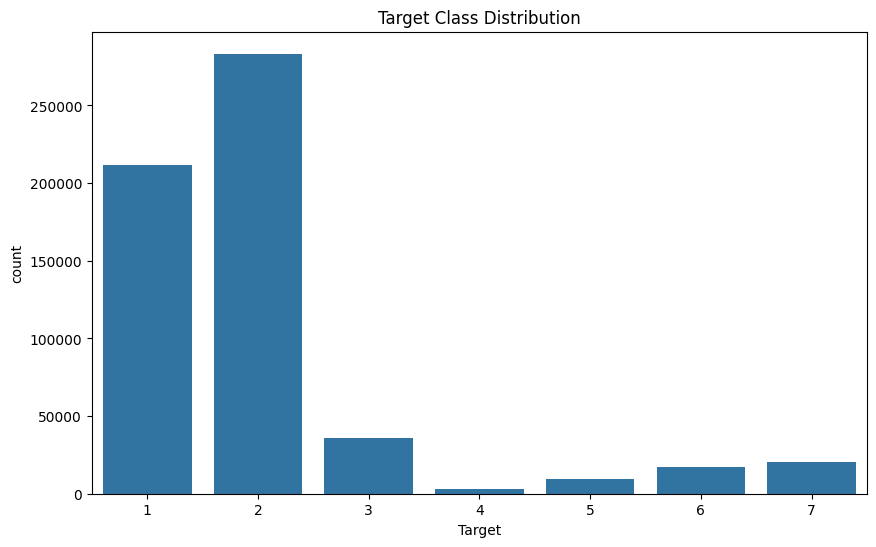

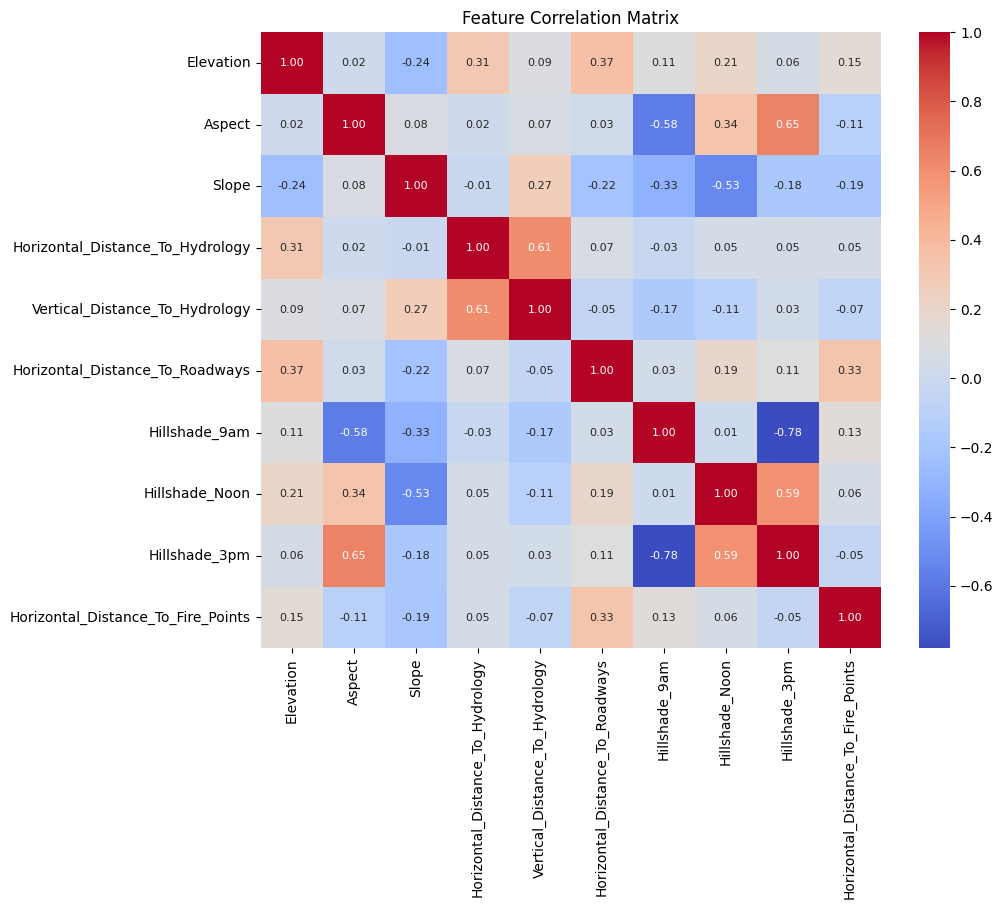

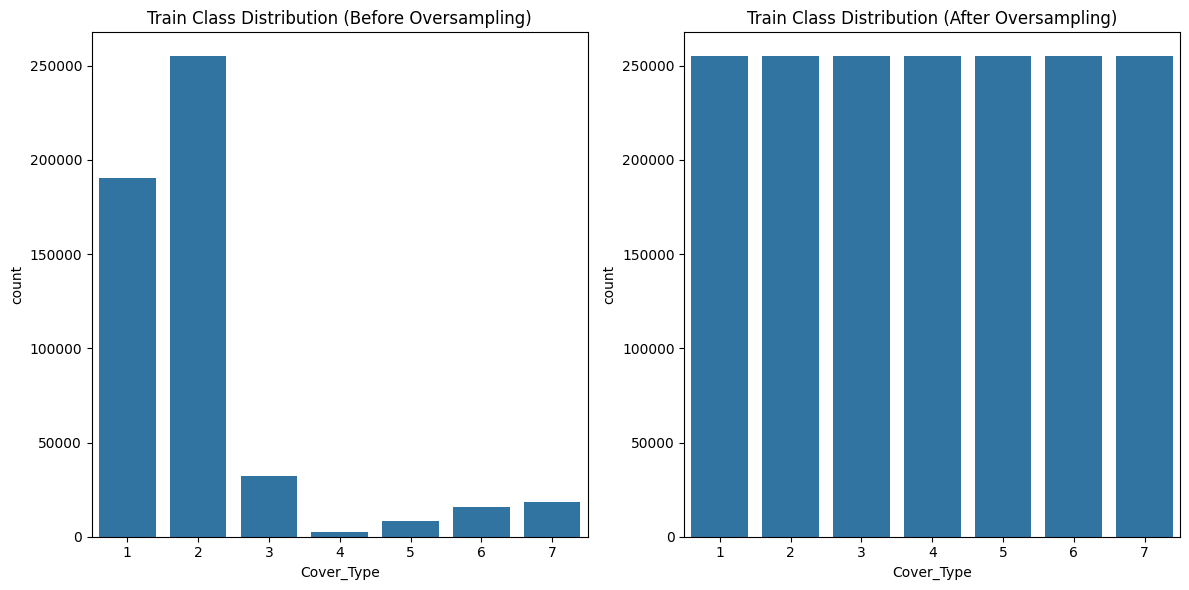

In [29]:
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Fetch dataset
covertype = fetch_ucirepo(id=31)
X = covertype.data.features
y = covertype.data.targets

# Clean the dataset by removing rows with null values
X = X.dropna()  # Drop any rows with missing (NaN) values
y = y.loc[X.index].reset_index(drop=True)  # Align y with X and reset index

# Clean any infinite values (if any)
X = X.replace([float('inf'), -float('inf')], float('nan'))  # Replace infinite values with NaN
X = X.dropna()  # Drop rows with NaN values again after replacing infinities
y = y.loc[X.index].reset_index(drop=True)  # Ensure the target variable aligns with the cleaned feature dataset

# Remove duplicate rows if there are any
X = X.drop_duplicates()
y = y.loc[X.index].reset_index(drop=True)  # Ensure the target variable aligns with the cleaned feature dataset

# Check for any null values (just to be safe)
print(f"Missing values in features: \n{X.isnull().sum()}")
print(f"Missing values in target: \n{y.isnull().sum()}")

# 1. EDA: Visualize the Target Class Distribution
data = X.copy()
data['Target'] = y

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', data=data)
plt.title('Target Class Distribution')
plt.show()

# 2. Visualize Distribution of Features (histograms)
numerical_cols = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]


# 4. Correlation Heatmap of Features
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, annot_kws={"size": 8})
plt.title('Feature Correlation Matrix')
plt.show()

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Initialize scaler
scaler = StandardScaler()

# Make copies and scale only numerical columns
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

#Oversample only training data (after scaling)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

# Plot before and after oversampling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=pd.Series(y_train.squeeze()))
plt.title("Train Class Distribution (Before Oversampling)")

plt.subplot(1, 2, 2)
sns.countplot(x=pd.Series(y_train_resampled.squeeze()))
plt.title("Train Class Distribution (After Oversampling)")

plt.tight_layout()
plt.show()

# Replace original datasets with processed ones
X_train = X_train_resampled
y_train = y_train_resampled
X_val = X_val_scaled
X_test = X_test_scaled
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
class ForestDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.squeeze().values - 1, dtype=torch.long)

    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_ds = ForestDataset(X_train, y_train)
val_ds = ForestDataset(X_val, y_val)
test_ds = ForestDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

In [37]:
import torch.nn as nn
import torch.nn.init as init

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(54, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 7)
        )

        # Apply He initialization (square of 2/n_l-1) to all Linear layers
        self.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, (nn.Linear)):
            # He initialization
            init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
            if layer.bias is not None:
                init.zeros_(layer.bias)  # Initialize bias to 0

    def forward(self, x):
        return self.net(x)


In [41]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = y_train.squeeze().values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert to PyTorch tensor and move to device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [42]:
def train(model, loader):
    model.train()
    running_loss, correct = 0.0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        correct += (outputs.argmax(1) == y).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            running_loss += loss.item() * X.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

In [43]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(30):
    train_loss, train_acc = train(model, train_dl)
    val_loss, val_acc = validate(model, val_dl)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Acc=0.7824, Val Acc=0.7353
Epoch 2: Train Acc=0.8145, Val Acc=0.7488
Epoch 3: Train Acc=0.8175, Val Acc=0.7552
Epoch 4: Train Acc=0.8187, Val Acc=0.7331
Epoch 5: Train Acc=0.8195, Val Acc=0.7463
Epoch 6: Train Acc=0.8401, Val Acc=0.7690
Epoch 7: Train Acc=0.8429, Val Acc=0.7829
Epoch 8: Train Acc=0.8435, Val Acc=0.7766
Epoch 9: Train Acc=0.8437, Val Acc=0.7787
Epoch 10: Train Acc=0.8445, Val Acc=0.7802
Epoch 11: Train Acc=0.8582, Val Acc=0.8049
Epoch 12: Train Acc=0.8607, Val Acc=0.8074
Epoch 13: Train Acc=0.8611, Val Acc=0.8033
Epoch 14: Train Acc=0.8608, Val Acc=0.8148
Epoch 15: Train Acc=0.8618, Val Acc=0.8083
Epoch 16: Train Acc=0.8708, Val Acc=0.8216
Epoch 17: Train Acc=0.8726, Val Acc=0.8254
Epoch 18: Train Acc=0.8733, Val Acc=0.8243
Epoch 19: Train Acc=0.8736, Val Acc=0.8237
Epoch 20: Train Acc=0.8736, Val Acc=0.8241
Epoch 21: Train Acc=0.8792, Val Acc=0.8293
Epoch 22: Train Acc=0.8808, Val Acc=0.8311
Epoch 23: Train Acc=0.8815, Val Acc=0.8373
Epoch 24: Train Acc=

Precision: 0.8661
Recall: 0.8465
F1-Score: 0.8514


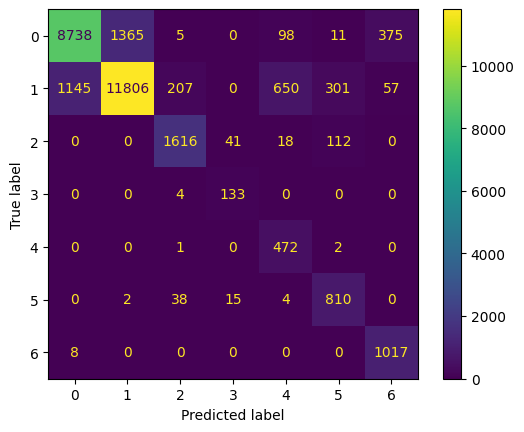

Test Accuracy: 0.8465


In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_dl:
        X = X.to(device)
        outputs = model(X)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())
cm = confusion_matrix(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
recall = recall_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f"Test Accuracy: {(np.array(all_preds) == np.array(all_labels)).mean():.4f}")

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with increased kernel sizes and added BatchNorm
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool1d(2)

        # Calculate the correct size after convolutions and pooling
        self.fc1_input_size = 128 * 6  # This should match the flattened output size

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc1_input_size, 512)  # Adjusted input size based on conv layers
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 7)

        # Dropout layers to reduce overfitting
        self.dropout = nn.Dropout(0.3)

        # BatchNorm layers for stability
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension [batch_size, 1, 54]

        # Convolutional layers with BatchNorm and LeakyReLU activations
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [batch_size, 32, 27]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [batch_size, 64, 13]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [batch_size, 128, 6]

        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 768]

        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.dropout(x)

        x = F.relu(self.fc2(x))  # Second fully connected layer
        x = self.dropout(x)

        x = F.relu(self.fc3(x))  # Third fully connected layer
        x = self.dropout(x)

        x = F.relu(self.fc4(x))  # Fourth fully connected layer
        x = self.dropout(x)

        x = F.relu(self.fc5(x))  # Fifth fully connected layer
        x = self.output(x)  # Final output layer

        return x


Epoch 1: Train Acc=0.8430, Val Acc=0.8107
Epoch 2: Train Acc=0.9016, Val Acc=0.8473
Epoch 3: Train Acc=0.9148, Val Acc=0.8497
Epoch 4: Train Acc=0.9217, Val Acc=0.8666
Epoch 5: Train Acc=0.9262, Val Acc=0.8661
Epoch 6: Train Acc=0.9448, Val Acc=0.8897
Epoch 7: Train Acc=0.9483, Val Acc=0.8949
Epoch 8: Train Acc=0.9500, Val Acc=0.8937
Epoch 9: Train Acc=0.9509, Val Acc=0.9006
Epoch 10: Train Acc=0.9521, Val Acc=0.9050
Epoch 11: Train Acc=0.9625, Val Acc=0.9209
Epoch 12: Train Acc=0.9644, Val Acc=0.9209
Epoch 13: Train Acc=0.9654, Val Acc=0.9189
Epoch 14: Train Acc=0.9661, Val Acc=0.9243
Epoch 15: Train Acc=0.9664, Val Acc=0.9228
Precision: 0.9259
Recall: 0.9229
F1-Score: 0.9234


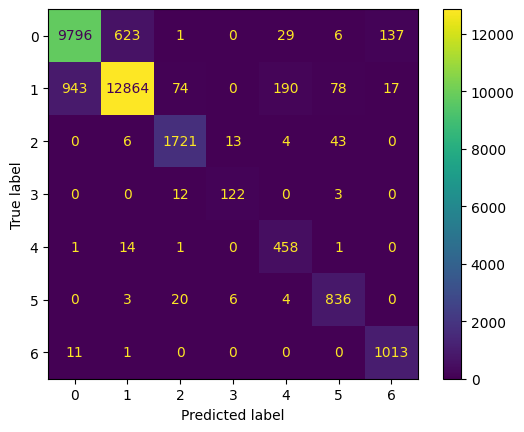

Test Accuracy: 0.9229


In [48]:
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model=ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(15):
    train_loss, train_acc = train(model, train_dl)
    val_loss, val_acc = validate(model, val_dl)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_dl:
        X = X.to(device)
        outputs = model(X)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())
cm = confusion_matrix(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
recall = recall_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f"Test Accuracy: {(np.array(all_preds) == np.array(all_labels)).mean():.4f}")